## Project 1

Start Date: Jan 27 2025

In [1]:
#Imports
import os

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import random
from itertools import combinations
from datetime import datetime
from collections import defaultdict, Counter

from lazypredict.Supervised import LazyClassifier
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, KFold, LeaveOneOut
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.feature_selection import RFE, RFECV, SelectKBest, mutual_info_classif, chi2
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Binarizer
from sklearn.compose import ColumnTransformer

from hyperopt import fmin, tpe,rand, hp, STATUS_OK,space_eval, Trials
from hyperopt.pyll.base import scope
from hyperopt.early_stop import no_progress_loss

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn import tree
from sklearn.ensemble import ExtraTreesClassifier, BaggingClassifier, AdaBoostClassifier, RandomForestClassifier
from sklearn.tree import ExtraTreeClassifier
from sklearn.ensemble import VotingClassifier, StackingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.inspection import partial_dependence, PartialDependenceDisplay
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import LinearSVC, SVC, NuSVC

from xgboost import plot_importance
from xgboost import plot_tree

from models import hyperOpt_NaiveBayes, hyperOpt_AdaBoost, hyperOpt_LinearSVC
#import shap


In [2]:
#seed = random.randint(1000, 9999)
seed = 3543 #2851 # 
np.random.seed(seed)
random.seed(seed)
print(seed)

3543


In [3]:
# Load the data
df = pd.read_csv("data/ACME-HappinessSurvey2020.csv")
df.head()

,Y,X1,X2,X3,X4,X5,X6
0,0,3,3,3,4,2,4
1,0,3,2,3,5,4,3
2,1,5,3,3,3,3,5
3,0,5,4,3,3,3,5
4,0,5,4,3,3,3,5


## Exploratory Data Analysis

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126 entries, 0 to 125
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Y       126 non-null    int64
 1   X1      126 non-null    int64
 2   X2      126 non-null    int64
 3   X3      126 non-null    int64
 4   X4      126 non-null    int64
 5   X5      126 non-null    int64
 6   X6      126 non-null    int64
dtypes: int64(7)
memory usage: 7.0 KB


In [5]:
df.describe()

,Y,X1,X2,X3,X4,X5,X6
count,126.00,126.00,126.00,126.00,126.00,126.00,126.00
mean,0.55,4.33,2.53,3.31,3.75,3.65,4.25
std,0.50,0.80,1.11,1.02,0.88,1.15,0.81
min,0.00,1.00,1.00,1.00,1.00,1.00,1.00
25%,0.00,4.00,2.00,3.00,3.00,3.00,4.00
50%,1.00,5.00,3.00,3.00,4.00,4.00,4.00
75%,1.00,5.00,3.00,4.00,4.00,4.00,5.00
max,1.00,5.00,5.00,5.00,5.00,5.00,5.00


All features except for X2 are left-skewed. X2 has a right-skew. Frequency plots below depict this. 

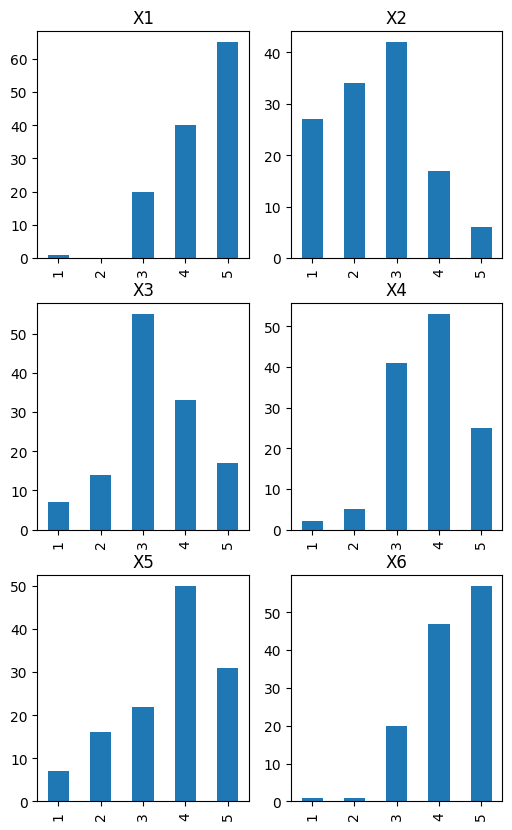

In [6]:
df_excluded = df.drop(columns=['Y'])

# Plot frequency bar plot for independent variables

# Values to count
values_to_count = [1, 2, 3, 4, 5]

# Frequency count for each column
frequency = df_excluded.apply(lambda col: col.value_counts().reindex(values_to_count, fill_value=0))

fig, axs = plt.subplots(3, 2, figsize=(6,10))
axs = axs.ravel()
idx = 0
for col in frequency.columns:
    frequency[col].plot(kind='bar', title=col, ax=axs[idx])
    idx+=1

plt.show()

When both independent and dependent attributes are ordinal, then we can use a rank correlation coefficient. Correlation analysis below evaluates correlations between each feature and target.

According to the results, X1, X3, X5 and X6 show the highest correlation to the target.

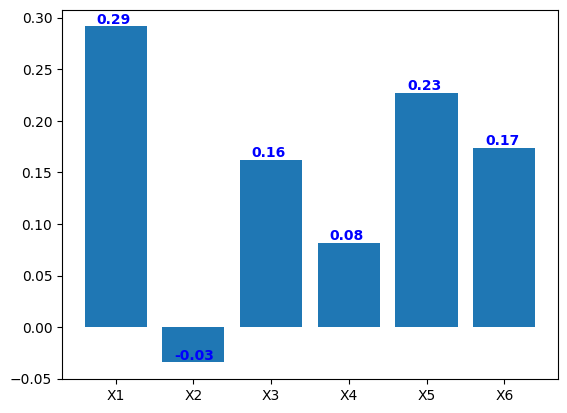

In [7]:
# Spearman's rank correlation to evaluate correlation between target variable and each feature
correlations = []
for col in df_excluded.columns:
    corr = df['Y'].corr(df_excluded[col], method='spearman')
    correlations.append(corr)

fig, ax = plt.subplots()
ax.bar([1,2,3,4,5,6], correlations, tick_label=['X1','X2','X3','X4','X5','X6'])

for i, v in enumerate(correlations):
    ax.text(i + 0.75,v + 0.003, '{:0.2f}'.format(v), 
            color = 'blue', fontweight = 'bold')
plt.show()

## Building classification models

In [8]:
features = ['X1', 'X2', 'X3', 'X4', 'X5', 'X6']
X = df[features]
Y = df['Y']

# Split into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=seed)

# Print the shapes of the resulting sets
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(100, 6) (26, 6) (100,) (26,)


In [9]:
# Setting 'unhappy' as the positive class
def recall_func(y_test, y_pred):
    return recall_score(y_test, y_pred, pos_label=0)

## Model selection

In [10]:
# Baselines
# LazyClassifier runs all models using their default settings. 
# Use this to get a sense of the top performing models and then finetune them.
# We are more interested predicting the unhappy class (class 0) correctly. So, we make it the positive class.
# We should improve recall. So, we select the best models based on recall. 
# F1 score is a combination of recall and precision. 


clf = LazyClassifier(verbose=-1,ignore_warnings=True, custom_metric=recall_func, predictions=True, random_state=seed)
models,predictions = clf.fit(x_train, x_test, y_train, y_test)

models

[('AdaBoostClassifier', <class 'sklearn.ensemble._weight_boosting.AdaBoostClassifier'>), ('BaggingClassifier', <class 'sklearn.ensemble._bagging.BaggingClassifier'>), ('BernoulliNB', <class 'sklearn.naive_bayes.BernoulliNB'>), ('CalibratedClassifierCV', <class 'sklearn.calibration.CalibratedClassifierCV'>), ('CategoricalNB', <class 'sklearn.naive_bayes.CategoricalNB'>), ('DecisionTreeClassifier', <class 'sklearn.tree._classes.DecisionTreeClassifier'>), ('DummyClassifier', <class 'sklearn.dummy.DummyClassifier'>), ('ExtraTreeClassifier', <class 'sklearn.tree._classes.ExtraTreeClassifier'>), ('ExtraTreesClassifier', <class 'sklearn.ensemble._forest.ExtraTreesClassifier'>), ('GaussianNB', <class 'sklearn.naive_bayes.GaussianNB'>), ('KNeighborsClassifier', <class 'sklearn.neighbors._classification.KNeighborsClassifier'>), ('LabelPropagation', <class 'sklearn.semi_supervised._label_propagation.LabelPropagation'>), ('LabelSpreading', <class 'sklearn.semi_supervised._label_propagation.LabelSp

100%|██████████| 29/29 [00:02<00:00, 12.78it/s]

[LightGBM] [Info] Number of positive: 53, number of negative: 47
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000031 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 31
[LightGBM] [Info] Number of data points in the train set: 100, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.530000 -> initscore=0.120144
[LightGBM] [Info] Start training from score 0.120144
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Ligh

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,recall_func,Time Taken
Model,,,,,,
BernoulliNB,0.88,0.91,0.91,0.89,1.00,0.02
AdaBoostClassifier,0.77,0.76,0.76,0.77,0.70,0.12
LinearDiscriminantAnalysis,0.73,0.72,0.72,0.73,0.70,0.02
RidgeClassifierCV,0.73,0.72,0.72,0.73,0.70,0.02
RidgeClassifier,0.73,0.72,0.72,0.73,0.70,0.02
LogisticRegression,0.73,0.72,0.72,0.73,0.70,0.02
LinearSVC,0.73,0.72,0.72,0.73,0.70,0.02
NearestCentroid,0.69,0.71,0.71,0.70,0.80,0.02
PassiveAggressiveClassifier,0.73,0.71,0.71,0.73,0.60,0.02


In [11]:
# Some Sklearn models do not have feature importance function.
# So, wrappers for those classifiers were created.
class MyBaggingClassifier(BaggingClassifier):
    @property
    def feature_importances_(self):
        feature_importances = np.mean([
            tree.feature_importances_ for tree in self.estimators_], axis=0)
        
        return feature_importances
    
class MyBernoulliNB(BernoulliNB):
    @property
    def feature_importances_(self):
        # Compute feature importance as absolute difference in log probabilities
        return np.abs(self.feature_log_prob_[1] - self.feature_log_prob_[0])

In [12]:
# Data pre-processing steps
preprocessor = Pipeline(
    steps=[("scaler", StandardScaler())] #("imputer", SimpleImputer(strategy="mean")), 
)

Based on the LazyPredictor results, three classifiers were selected, each representing a distinct category:
- BernoulliNB - probabilistic
- AdaBoost - ensemble method
- LinearSVC - linear model 

   Accuracy  Recall  Precision
0      0.88    1.00       0.77
1      0.77    0.70       0.70
2      0.73    0.70       0.64


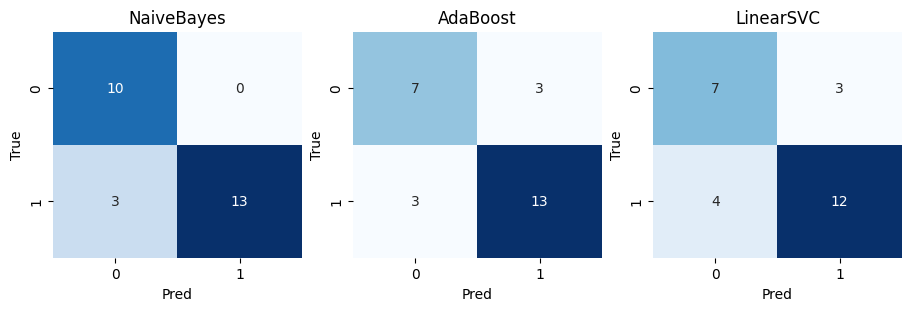

In [13]:
# Re-training the selected models to evaluate consistency with LazyPredict results

classifiers = {
    'NaiveBayes': MyBernoulliNB(),
    'AdaBoost': AdaBoostClassifier(random_state=seed),
    'LinearSVC': LinearSVC(random_state=seed)
}


fig, ax = plt.subplots(1, 3, figsize=(9,3), constrained_layout=True)

metrics = []
importances = []

for idx, (clf_name, clf) in enumerate(classifiers.items()):

    model = Pipeline([
    ("preprocessing", preprocessor),
    ("classifier", clf)
    ])

    model.fit(x_train, y_train) #clf.fit(x_train, y_train, eval_set=[(x_test, y_test)]) #(eval_set for early stopping)

    # Make predictions
    y_pred = model.predict(x_test)

    accuracy = accuracy_score(y_test, y_pred,normalize=True)
    precision = precision_score(y_test, y_pred, pos_label=0)
    recall = recall_score(y_test, y_pred, pos_label=0)

    metrics.append([accuracy, recall, precision])

    cm = confusion_matrix(y_test, y_pred)
    s = sns.heatmap(cm, ax = ax[idx], cbar = False, annot=True, cmap='Blues')
    s.set_xlabel('Pred')
    s.set_ylabel('True')
    s.set_title(clf_name)

metrics_df = pd.DataFrame(metrics, columns=['Accuracy', 'Recall', 'Precision'])

print(metrics_df)
plt.show()

## Feature selection

In [14]:
# Defining recall with unhappy class as the positive class as the scoring function
def my_scorer(estimator, x, y):
    
    y_pred = estimator.predict(x)
    score = recall_score(y, y_pred, pos_label=0)

    return score

#### Two methods were considered for feature selection
1. Exhaustively searching the whole feature space by considering every feature combination
1. Recursive feature elimination with cross validation

The first method is in-efficient and time consuming, especially when cross validation is used for evaluation.
With the second method, we can use cross validation to determine the optimal number of features required.

In [15]:
# UNCOMMENT TO RUN

# ## Feature-wise classification
# results = {clf_name:[] for clf_name in classifiers.keys()}
# loo = LeaveOneOut()

# for idx, (clf_name, clf) in enumerate(classifiers.items()):
#     best_combinations = []
#     for i in range(1, len(features)+1):
#         for combo in combinations(features, i):
#             X_subset = df[list(combo)]
#             x_train_subset, x_test_subset, y_train, y_test = train_test_split(X_subset, Y, test_size=0.2, random_state=seed)

#             model = Pipeline([
#                 ("preprocessing", preprocessor),
#                 ("classifier", clf)
#             ])

#             scores = cross_val_score(model, x_train_subset, y_train, cv=loo, scoring=my_scorer)
#             avg_score = np.mean(scores)
#             model.fit(x_train_subset, y_train)

#             # Make predictions
#             y_pred = model.predict(x_test_subset)
#             accuracy = accuracy_score(y_test, y_pred)
#             precision = precision_score(y_test, y_pred, pos_label=0)
#             recall = recall_score(y_test, y_pred, pos_label=0)

#             best_combinations.append((combo, avg_score, accuracy, recall, precision))
    
#     best_combinations.sort(key=lambda x:x[1], reverse=True)
#     results[clf_name] = best_combinations[:3]

# final_result = []

# for clf_name, top_combos in results.items():
#     for combo, score, acc, recall, precision in top_combos:
#         final_result.append({'Classifier':clf_name, 'Features':combo, 'Cross-val Score':score, 'Accuracy':acc, 'Precision':precision, 'Recall':recall})

# final_df = pd.DataFrame(final_result)
# print(final_df)
            
        

I do an initial hyperparameter tuning for with entire feature set before feature selection.

  3%|▎         | 14/500 [00:10<06:13,  1.30trial/s, best loss: -0.24]

 Time taken: 0 hours 0 minutes and 10.77 seconds.
Best hyperparameters: {'alpha': 0.040264229636336565, 'binarize': 0.737690850824399, 'fit_prior': True}
   Accuracy  Recall  Precision
0      0.85    0.80       0.80


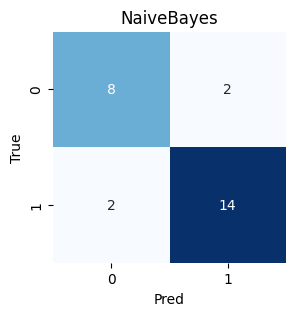

  3%|▎         | 14/500 [04:06<2:22:28, 17.59s/trial, best loss: -0.22]
Best hyperparameters: {'algorithm': 'SAMME', 'learning_rate': 0.3502049947378976, 'n_estimators': 50}
   Accuracy  Recall  Precision
0      0.85    0.80       0.80


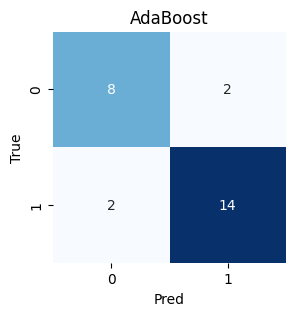

  4%|▍         | 19/500 [00:15<06:32,  1.22trial/s, best loss: -0.19]
Best hyperparameters: {'C': 0.013433227072091682, 'loss': 'hinge', 'max_iter': 4500, 'tol': 0.0500466063883078}
   Accuracy  Recall  Precision
0      0.73    0.70       0.64


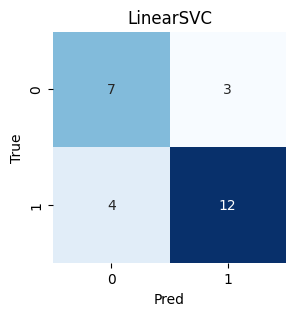

In [16]:
best_params_all1 = {}
best_params_all1['NaiveBayes'] = hyperOpt_NaiveBayes(df[features], Y, preprocessor, my_scorer, seed)
best_params_all1['AdaBoost'] = hyperOpt_AdaBoost(df[features], Y, preprocessor, my_scorer, seed)
best_params_all1['LinearSVC'] = hyperOpt_LinearSVC(df[features], Y, preprocessor, my_scorer, seed)

Recursive feature elimination identified the most influential predictors across all three models. Given the dataset's limited size, leave-one-out cross-validation was employed for both feature selection and hyperparameter optimization.

Feature selection findings below align with the earlier correlation analysis, confirming that variables X1, X3, X5, and X6 demonstrate the strongest relationships with the target variable.

In [17]:
## Recursive feature elimination
results = {clf_name:[] for clf_name in classifiers.keys()}
features_subset = []
for idx, (clf_name, clf) in enumerate(classifiers.items()):
    
    clf.set_params(**best_params_all1[clf_name])
    loo = LeaveOneOut()
    
    print(f"Processing: {clf_name}")

    #rfe = RFE(clf, n_features_to_select=3)
    rfecv = RFECV(estimator=clf, step=1, cv=loo, scoring=my_scorer, n_jobs=-1)
    model = Pipeline([
        ("preprocessing", preprocessor),
        ("feature_selection", rfecv),
        ("classifier", clf)
    ])

    model.fit(x_train, y_train)

    # Print ranking of features
    selected_features = np.array(features)[rfecv.support_]
    features_subset.append(list(selected_features))
    print(f"Optimal Number of Features: {rfecv.n_features_}")
    print(f"Ranking: {rfecv.ranking_}")
    print(f"Selected Features: {selected_features}")
        

Processing: NaiveBayes
Optimal Number of Features: 1
Ranking: [3 5 2 4 1 6]
Selected Features: ['X5']
Processing: AdaBoost
Optimal Number of Features: 5
Ranking: [1 2 1 1 1 1]
Selected Features: ['X1' 'X3' 'X4' 'X5' 'X6']
Processing: LinearSVC
Optimal Number of Features: 4
Ranking: [1 2 1 3 1 1]
Selected Features: ['X1' 'X3' 'X5' 'X6']


In [18]:
features_subset

[['X5'], ['X1', 'X3', 'X4', 'X5', 'X6'], ['X1', 'X3', 'X5', 'X6']]

In [19]:
#rfecv.cv_results_

Since feature selection prioritized minimizing recall, the chosen features may result in lower precision and accuracy.

Processing: NaiveBayes
Processing: AdaBoost
Processing: LinearSVC
   Accuracy  Recall  Precision
0      0.58    1.00       0.48
1      0.85    0.80       0.80
2      0.73    0.70       0.64


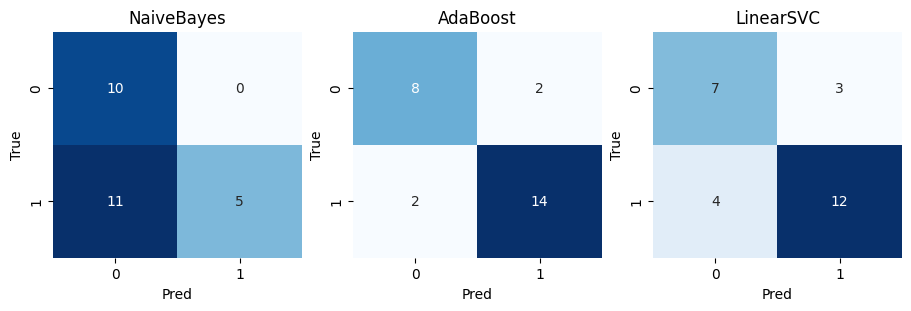

In [20]:
## Evaluating feature selection
fig, ax = plt.subplots(1, 3, figsize=(9,3), constrained_layout=True)
metrics = []
importances = []
for idx, (clf_name, clf) in enumerate(classifiers.items()): 
    print(f"Processing: {clf_name}")
    X_subset = df[features_subset[idx]]
    x_train_subset, x_test_subset, y_train, y_test = train_test_split(X_subset, Y, test_size=0.2, random_state=seed)

    model = Pipeline([
            ("preprocessing", preprocessor),
            ("classifier", clf)
        ])


    model.fit(x_train_subset, y_train)

    # Make predictions
    y_pred = model.predict(x_test_subset)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, pos_label=0)
    recall = recall_score(y_test, y_pred, pos_label=0)

    metrics.append([accuracy, recall, precision])

    cm = confusion_matrix(y_test, y_pred)
    s = sns.heatmap(cm, ax = ax[idx], cbar = False, annot=True, cmap='Blues')
    s.set_xlabel('Pred')
    s.set_ylabel('True')
    s.set_title(clf_name)

metrics_df = pd.DataFrame(metrics, columns=['Accuracy', 'Recall', 'Precision'])
print(metrics_df)
plt.show()

## Hyperparameter tuning


  2%|▏         | 12/500 [00:09<06:41,  1.21trial/s, best loss: -0.38]

 Time taken: 0 hours 0 minutes and 9.88 seconds.
Best hyperparameters: {'alpha': 0.12901808982310917, 'binarize': 0.4154456199995351, 'fit_prior': True}
   Accuracy  Recall  Precision
0      0.58    1.00       0.48


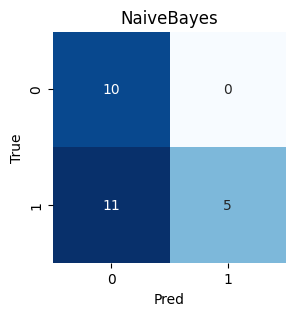

  3%|▎         | 14/500 [03:40<2:07:29, 15.74s/trial, best loss: -0.22]
Best hyperparameters: {'algorithm': 'SAMME', 'learning_rate': 0.3502049947378976, 'n_estimators': 50}
   Accuracy  Recall  Precision
0      0.85    0.80       0.80


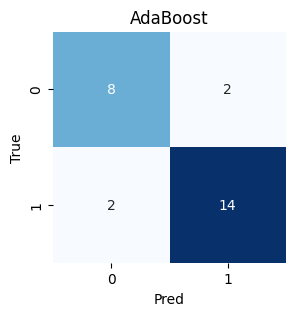

  4%|▍         | 19/500 [00:13<05:41,  1.41trial/s, best loss: -0.2]
Best hyperparameters: {'C': 0.013433227072091682, 'loss': 'hinge', 'max_iter': 4500, 'tol': 0.0500466063883078}
   Accuracy  Recall  Precision
0      0.73    0.70       0.64


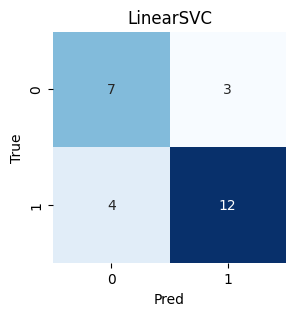

In [21]:
best_params_all = {}
best_params_all['NaiveBayes'] = hyperOpt_NaiveBayes(df[features_subset[0]], Y, preprocessor, my_scorer, seed)
best_params_all['AdaBoost'] = hyperOpt_AdaBoost(df[features_subset[1]], Y, preprocessor, my_scorer, seed)
best_params_all['LinearSVC'] = hyperOpt_LinearSVC(df[features_subset[2]], Y, preprocessor, my_scorer, seed)

#best_params_all.keys()

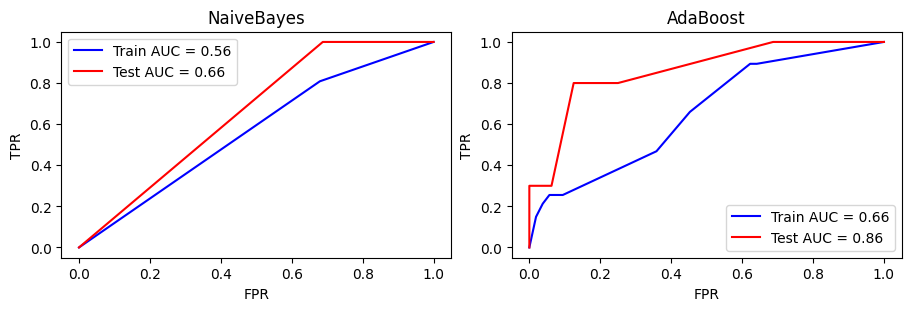

In [25]:
fig, ax = plt.subplots(1, 2, figsize=(9,3), constrained_layout=True)

for idx, (clf_name, clf) in enumerate(classifiers.items()):
    
    # LinearSVC does not define 'predict_proba' values required for ROC computation
    if clf_name == 'LinearSVC':
        continue
    
    X_subset = df[features_subset[idx]]
    x_train_subset, x_test_subset, y_train, y_test = train_test_split(X_subset, Y, test_size=0.2, random_state=seed)

    clf.set_params(**best_params_all[clf_name])
    
    model = Pipeline([
        ("preprocessing", preprocessor),
        ("classifier", clf)
    ])

    model.fit(x_train_subset, y_train)

    y_probs_train = model.predict_proba(x_train_subset)[:,0] # Positive class is 0
    y_probs_test = model.predict_proba(x_test_subset)[:,0] # Positive class is 0

    fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_probs_train, pos_label=0)
    fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_probs_test, pos_label=0)

    roc_auc_train = auc(fpr_train, tpr_train)
    roc_auc_test = auc(fpr_test, tpr_test)

    ax[idx].plot(fpr_train, tpr_train, 'b', label='Train AUC = {:0.2f}'.format(roc_auc_train))
    ax[idx].plot(fpr_test, tpr_test, 'r', label='Test AUC = {:0.2f}'.format(roc_auc_test))
    ax[idx].legend()
    ax[idx].set_title(clf_name)
    ax[idx].set_xlabel('FPR')
    ax[idx].set_ylabel('TPR')

plt.show()

Despite achieving perfect recall, the Naive Bayes classifier's accuracy approximates random classification, indicating poor overall performance. The LinearSVC has delivered substandard results. Based on comprehensive evaluation metrics, the AdaBoost classifier was selected as the final predictive model.

## Voting and stacking 

The architectural diversity among the selected models—Naive Bayes, AdaBoost, and SVC—enables them to capture complementary patterns in the data. Leveraging this diversity, voting and stacking ensemble techniques were implemented to integrate these structurally distinct classifiers, potentially enhancing predictive performance beyond what any individual model could achieve alone.

Classification results show that the ensemble models outperform the individual models.

In [23]:
y_preds = {}

# Hard voting 
clf1 = MyBernoulliNB()
clf2 = AdaBoostClassifier(random_state=seed)
clf3 = SVC(random_state=seed, probability=True)

eclf1 = VotingClassifier(estimators=[('nb', clf1), ('aboost', clf2), ('lnsvc', clf3)],voting='hard')

model1 = Pipeline([
            ("preprocessing", preprocessor),
            ("classifier", eclf1)
])

model1.fit(x_train, y_train)
y_preds['hard'] = model1.predict(x_test)

# Soft voting
clf1 = MyBernoulliNB()
clf2 = AdaBoostClassifier(random_state=seed)
clf3 = SVC(random_state=seed, probability=True)

eclf2 = VotingClassifier(estimators=[('nb', clf1), ('aboost', clf2), ('lnsvc', clf3)], voting='soft')

model2 = Pipeline([
            ("preprocessing", preprocessor),
            ("classifier", eclf2)
])

model2.fit(x_train, y_train)
y_preds['soft'] = model2.predict(x_test)

# Soft voting with weights
clf1 = MyBernoulliNB()
clf2 = AdaBoostClassifier(random_state=seed)
clf3 = SVC(random_state=seed, probability=True)

eclf3 = VotingClassifier(estimators=[('nb', clf1), ('aboost', clf2), ('lnsvc', clf3)], voting='soft', weights=[2, 1, 1])

model3 = Pipeline([
            ("preprocessing", preprocessor),
            ("classifier", eclf3)
])

model3.fit(x_train, y_train)
y_preds['weighted'] = model3.predict(x_test)

# Print accuracy scores
metrics = []
for model_name, preds in y_preds.items():

    accuracy = accuracy_score(y_test, preds)
    precision = precision_score(y_test, preds, pos_label=0)
    recall = recall_score(y_test, preds, pos_label=0)

    metrics.append([accuracy, recall, precision])

metrics_df = pd.DataFrame(metrics, columns=['Accuracy', 'Recall', 'Precision'])
print(metrics_df)

   Accuracy  Recall  Precision
0      0.85    0.90       0.75
1      0.88    0.90       0.82
2      0.88    0.90       0.82


In [24]:
# Stacking classifier

clf1 = MyBernoulliNB()
clf2 = AdaBoostClassifier(random_state=seed)
clf3 = SVC(random_state=seed, probability=True)

# Define the base models
estimators = [('nb', clf1), ('aboost', clf2), ('lnsvc', clf3)]
final_estimator = XGBClassifier(random_state=seed)

eclf4 = StackingClassifier(estimators=estimators,final_estimator=final_estimator,cv=loo)

model4 = Pipeline([
            ("preprocessing", preprocessor),
            ("classifier", eclf4)
])


model4.fit(x_train, y_train)
y_pred = model4.predict(x_test)

accuracy = accuracy_score(y_test, preds)
precision = precision_score(y_test, preds, pos_label=0)
recall = recall_score(y_test, preds, pos_label=0)

metrics = [[accuracy, recall, precision]]
metrics_df = pd.DataFrame(metrics, columns=['Accuracy', 'Recall', 'Precision'])
print(metrics_df)

   Accuracy  Recall  Precision
0      0.88    0.90       0.82


## Conclusion:

My analysis aimed to predict unhappy customers (unhappy = positive class), since focusing on dissatisfied is more crucial at this stage. **It's important to acknowledge that this analysis was conducted on a relatively small dataset, which inherently limits the generalizability and stability of the findings.** I explored various classification models, feature selection techniques, and ensemble methods to optimize predictive performance. Out of 30 classification models, 3 were selected based on baseline recall metrics. While the Naive Bayes and LinearSVC models demonstrated limited effectiveness, the AdaBoost classifier emerged as the most robust individual model, particularly after rigorous feature selection using Recursive Feature Elimination with Leave-One-Out Cross-Validation.

My findings underscore the significance of specific factors—on-time delivery (X1), order completeness (X3), courier satisfaction (X5), and app usability (X6)—in reducing customer dissatisfaction. Notably, ensemble methods, specifically voting and stacking, significantly improved predictive accuracy and recall compared to individual models. This highlights the value of combining diverse model architectures to capture complex data patterns and enhance overall prediction capabilities. **However, the small dataset size means that these patterns may not be fully representative of the broader customer base.**

## Recommendations:

1.  **Prioritize Operational Improvements in Key Areas:**
    * The strong correlation between dissatisfaction and factors X1, X3, X5, and X6 necessitates focused operational improvements.
    * **X1 (On-Time Delivery):** Implement real-time tracking, optimize delivery routes, and provide proactive communication regarding delays. Invest in technology to improve delivery time predictability.
    * **X3 (Order Completeness):** Enhance inventory management, improve order verification processes, and ensure clear communication regarding item availability.
    * **X5 (Courier Satisfaction):** Invest in courier training, provide competitive compensation, and foster a supportive work environment. Happy couriers lead to happy customers.
    * **X6 (App Usability):** Conduct regular user testing, simplify the ordering process, and address any technical glitches promptly.
2.  **Leverage the AdaBoost Ensemble Model for Prediction:**
    * The AdaBoost ensemble model, enhanced by voting or stacking, demonstrated the highest predictive performance. Integrate this model into the customer feedback analysis pipeline.
    * Use the model to create a early warning system to flag customers that are likely to be unhappy. 
3.  **Prioritize Dataset Expansion:**
    * Implement strategies to gather feedback from a wider range of customers, including those who may not typically respond to surveys.
    * Explore methods such as in-app feedback prompts, post-delivery surveys, and social media monitoring to increase data collection.
4.  **Invest in Feature Engineering:**
    * While the current features provide valuable insights, explore additional data sources and feature engineering techniques to further enhance predictive accuracy.
    * Consider factors such as delivery distance, order frequency, and customer demographics.
6.  **Focus on "Unhappy" Customer Recovery:**
    * Develop targeted strategies for addressing and resolving the issues identified by the predictive model.
    * Proactive outreach to potentially unhappy customers can mitigate negative experiences and build customer loyalty.